In [1]:
!pip install pennylane
from IPython.display import clear_output
clear_output()


In [2]:
import pennylane as qml
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

import torch
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from skimage.transform import resize
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from sklearn.preprocessing import OneHotEncoder
import math
import threading


device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cpu


In [3]:
# Standard Libraries
import os
import cv2


# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set dataset path
DATASET_PATH = "/content/drive/MyDrive/COVID-19 Lung CT Scans_FULL"
COVID_PATH = os.path.join(DATASET_PATH, "/content/drive/MyDrive/COVID-19 Lung CT Scans_FULL/COVID-19")
NONCOVID_PATH = os.path.join(DATASET_PATH, "/content/drive/MyDrive/COVID-19 Lung CT Scans_FULL/Non-COVID-19")


In [4]:
# Check first few image shapes (without resizing)
def check_original_shapes(folder, label_name, num_samples=5):
    print(f"\nChecking {label_name} images:")
    count = 0
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            print(f"{filename}: {img.shape}")  # (height, width)
            count += 1
        if count >= num_samples:
            break

# Show shapes
check_original_shapes(COVID_PATH, "COVID-19")
check_original_shapes(NONCOVID_PATH, "Non-COVID-19")


Checking COVID-19 images:
COVID-19_6435.png: (512, 512)
COVID-19_6553.png: (512, 512)
COVID-19_6445.png: (512, 512)
COVID-19_6437.png: (512, 512)
COVID-19_6485.png: (512, 512)

Checking Non-COVID-19 images:
Non-COVID-19_163.png: (512, 512)
Non-COVID-19_067.png: (512, 512)
Non-COVID-19_040.png: (512, 512)
Non-COVID-19_063.png: (512, 512)
Non-COVID-19_103.png: (512, 512)


In [5]:

def load_images_from_folder(folder_path, label, img_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(label)
    return images, labels

# Load COVID and Non-COVID images
covid_images, covid_labels = load_images_from_folder(COVID_PATH, 1)
noncovid_images, noncovid_labels = load_images_from_folder(NONCOVID_PATH, 0)

# Combine and convert to numpy arrays
X = np.array(covid_images + noncovid_images)
y = np.array(covid_labels + noncovid_labels)

# Expand dimensions for CNN
X = X.reshape(-1, 128, 128, 1) / 255.0

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# Resize images to 16x16 for Amplitude Embedding (256 features for 8 qubits)
# Assuming X_train and X_test are already loaded and preprocessed as numpy arrays
X_train_resized = X_train.reshape(-1, 128, 128) # Remove the channel dimension for resizing
X_test_resized = X_test.reshape(-1, 128, 128)

# Use cv2.resize for resizing
X_train_resized = np.array([cv2.resize(img, (16, 16)) for img in X_train_resized])
X_test_resized = np.array([cv2.resize(img, (16, 16)) for img in X_test_resized])

# Flatten the resized images to a 1D vector of size 256
X_train_flat = X_train_resized.reshape(-1, 16*16)
X_test_flat = X_test_resized.reshape(-1, 16*16)

print(f"Resized and flattened training data shape: {X_train_flat.shape}")
print(f"Resized and flattened testing data shape: {X_test_flat.shape}")


Resized and flattened training data shape: (6752, 256)
Resized and flattened testing data shape: (1688, 256)


In [8]:
import pennylane as qml
import numpy as np

# Set up the device with 10 qubits (9 for features, 1 for ancilla)
dev = qml.device("default.qubit", wires=10)

# Define the quantum circuit
@qml.qnode(dev, interface='autograd') # Using autograd interface for numpy arrays
def quantum_circuit(features, phis):
    # Amplitude encoding with equal amplitudes for all 512 states (2^9 = 512)
    qml.AmplitudeEmbedding(features=features, wires=range(9), normalize=True, pad_with=0)

    # First Convolution
    qml.CRY(phi=phis[0], wires=[8, 7])
    qml.CRY(phi=phis[1], wires=[7, 6])
    qml.CRY(phi=phis[2], wires=[6, 5])
    qml.CRY(phi=phis[3], wires=[5, 8])
    qml.CRY(phi=phis[4], wires=[4, 3])
    qml.CRY(phi=phis[5], wires=[3, 2])
    qml.CRY(phi=phis[6], wires=[2, 1])
    qml.CRY(phi=phis[7], wires=[1, 0])
    qml.CRY(phi=phis[8], wires=[0, 4])
    qml.Barrier()

    # First Pooling
    qml.CRZ(phi=phis[9], wires=[8, 7])
    qml.X(wires=8)
    qml.CRX(phi=phis[10], wires=[8, 7])
    qml.CRZ(phi=phis[9], wires=[4, 3])
    qml.X(wires=4)
    qml.CRX(phi=phis[10], wires=[4, 3])
    qml.Barrier()

    # Activations 1
    for w, phi in zip([0, 1, 2, 5, 6, 7], phis[11:17]):
        qml.Hadamard(wires=w)
        qml.RZ(phi=phi, wires=w)
    qml.Barrier()

    # Second Convolution
    qml.CRY(phi=phis[17], wires=[7, 6])
    qml.CRY(phi=phis[18], wires=[6, 5])
    qml.CRY(phi=phis[19], wires=[5, 7])
    qml.CRY(phi=phis[20], wires=[3, 2])
    qml.CRY(phi=phis[21], wires=[2, 1])
    qml.CRY(phi=phis[22], wires=[1, 3])
    qml.Barrier()

    # Second Pooling
    qml.CRZ(phi=phis[23], wires=[7, 6])
    qml.X(wires=7)
    qml.CRX(phi=phis[24], wires=[7, 6])
    qml.CRZ(phi=phis[23], wires=[3, 2])
    qml.X(wires=3)
    qml.CRX(phi=phis[24], wires=[3, 2])
    qml.Barrier()

    # Activations 2
    for w, phi in zip([0, 1, 5, 6], phis[25:29]):
        qml.Hadamard(wires=w)
        qml.RZ(phi=phi, wires=w)
    qml.Barrier()

    # Third Convolution
    qml.CRY(phi=phis[29], wires=[6, 5])
    qml.CRY(phi=phis[30], wires=[5, 6])
    qml.CRY(phi=phis[31], wires=[1, 0])
    qml.CRY(phi=phis[32], wires=[0, 1])
    qml.Barrier()

    # Third Pooling
    qml.CRZ(phi=phis[33], wires=[6, 5])
    qml.X(wires=6)
    qml.CRX(phi=phis[34], wires=[6, 5])
    qml.CRZ(phi=phis[33], wires=[1, 0])
    qml.X(wires=1)
    qml.CRX(phi=phis[34], wires=[1, 0])

    # Single ancilla qubit (wire 9)
    qml.CNOT(wires=[0, 9])   # connect final feature qubit to ancilla

    # Return expectation value for binary classification
    return qml.expval(qml.PauliZ(9))

In [9]:
num_feature_qubits = 9
num_features = 2 ** num_feature_qubits  # 512

# Example: normalize a random input
features = np.random.rand(num_features)
features = features / np.linalg.norm(features)

In [10]:
# Make sure phis length matches the circuit definition
num_phis = 35
phis = np.random.uniform(-np.pi, np.pi, size=num_phis)

result = quantum_circuit(features, phis)
print(result)


0.47042750355706603


In [11]:
# Number of parameters used in the circuit
num_phis = 35

# Random normalized feature vector (512 amplitudes)
features = np.random.rand(512)
features = features / np.linalg.norm(features)

# Random parameters
phis = np.random.uniform(-np.pi, np.pi, size=num_phis)

# Run the circuit once
result = quantum_circuit(features, phis)
print("Single result:", result)

# Run multiple times and collect results
results = []
for _ in range(10):  # e.g., 10 runs
    phis = np.random.uniform(-np.pi, np.pi, size=num_phis)  # new params each run
    results.append(quantum_circuit(features, phis))

print("Results:", results)


Single result: 0.22187820467643815
Results: [tensor(0.30371182, requires_grad=True), tensor(-0.0667167, requires_grad=True), tensor(-0.03892595, requires_grad=True), tensor(-0.07956589, requires_grad=True), tensor(-0.06081656, requires_grad=True), tensor(-0.05762757, requires_grad=True), tensor(-0.29218282, requires_grad=True), tensor(-0.15323242, requires_grad=True), tensor(-0.01394682, requires_grad=True), tensor(-0.04556589, requires_grad=True)]


0: ─╭|Ψ⟩────────────────────────────────╭RY(-1.73)─╭●─────────||─────────────────────────||──H ···
1: ─├|Ψ⟩─────────────────────╭RY(0.95)──╰●─────────│──────────||─────────────────────────||──H ···
2: ─├|Ψ⟩───────────╭RY(2.52)─╰●────────────────────│──────────||─────────────────────────||──H ···
3: ─├|Ψ⟩─╭RY(0.45)─╰●──────────────────────────────│──────────||─╭RZ(0.24)────╭RX(0.92)──||─── ···
4: ─├|Ψ⟩─╰●────────────────────────────────────────╰RY(2.10)──||─╰●─────────X─╰●─────────||─── ···
5: ─├|Ψ⟩─────────────────────╭RY(-1.31)─╭●────────────────────||─────────────────────────||──H ···
6: ─├|Ψ⟩───────────╭RY(1.71)─╰●─────────│─────────────────────||─────────────────────────||──H ···
7: ─├|Ψ⟩─╭RY(2.56)─╰●───────────────────│─────────────────────||─╭RZ(0.24)────╭RX(0.92)──||──H ···
8: ─╰|Ψ⟩─╰●─────────────────────────────╰RY(2.06)─────────────||─╰●─────────X─╰●─────────||─── ···
9: ───────────────────────────────────────────────────────────||─────────────────────────||─── ···

0: ··· ──

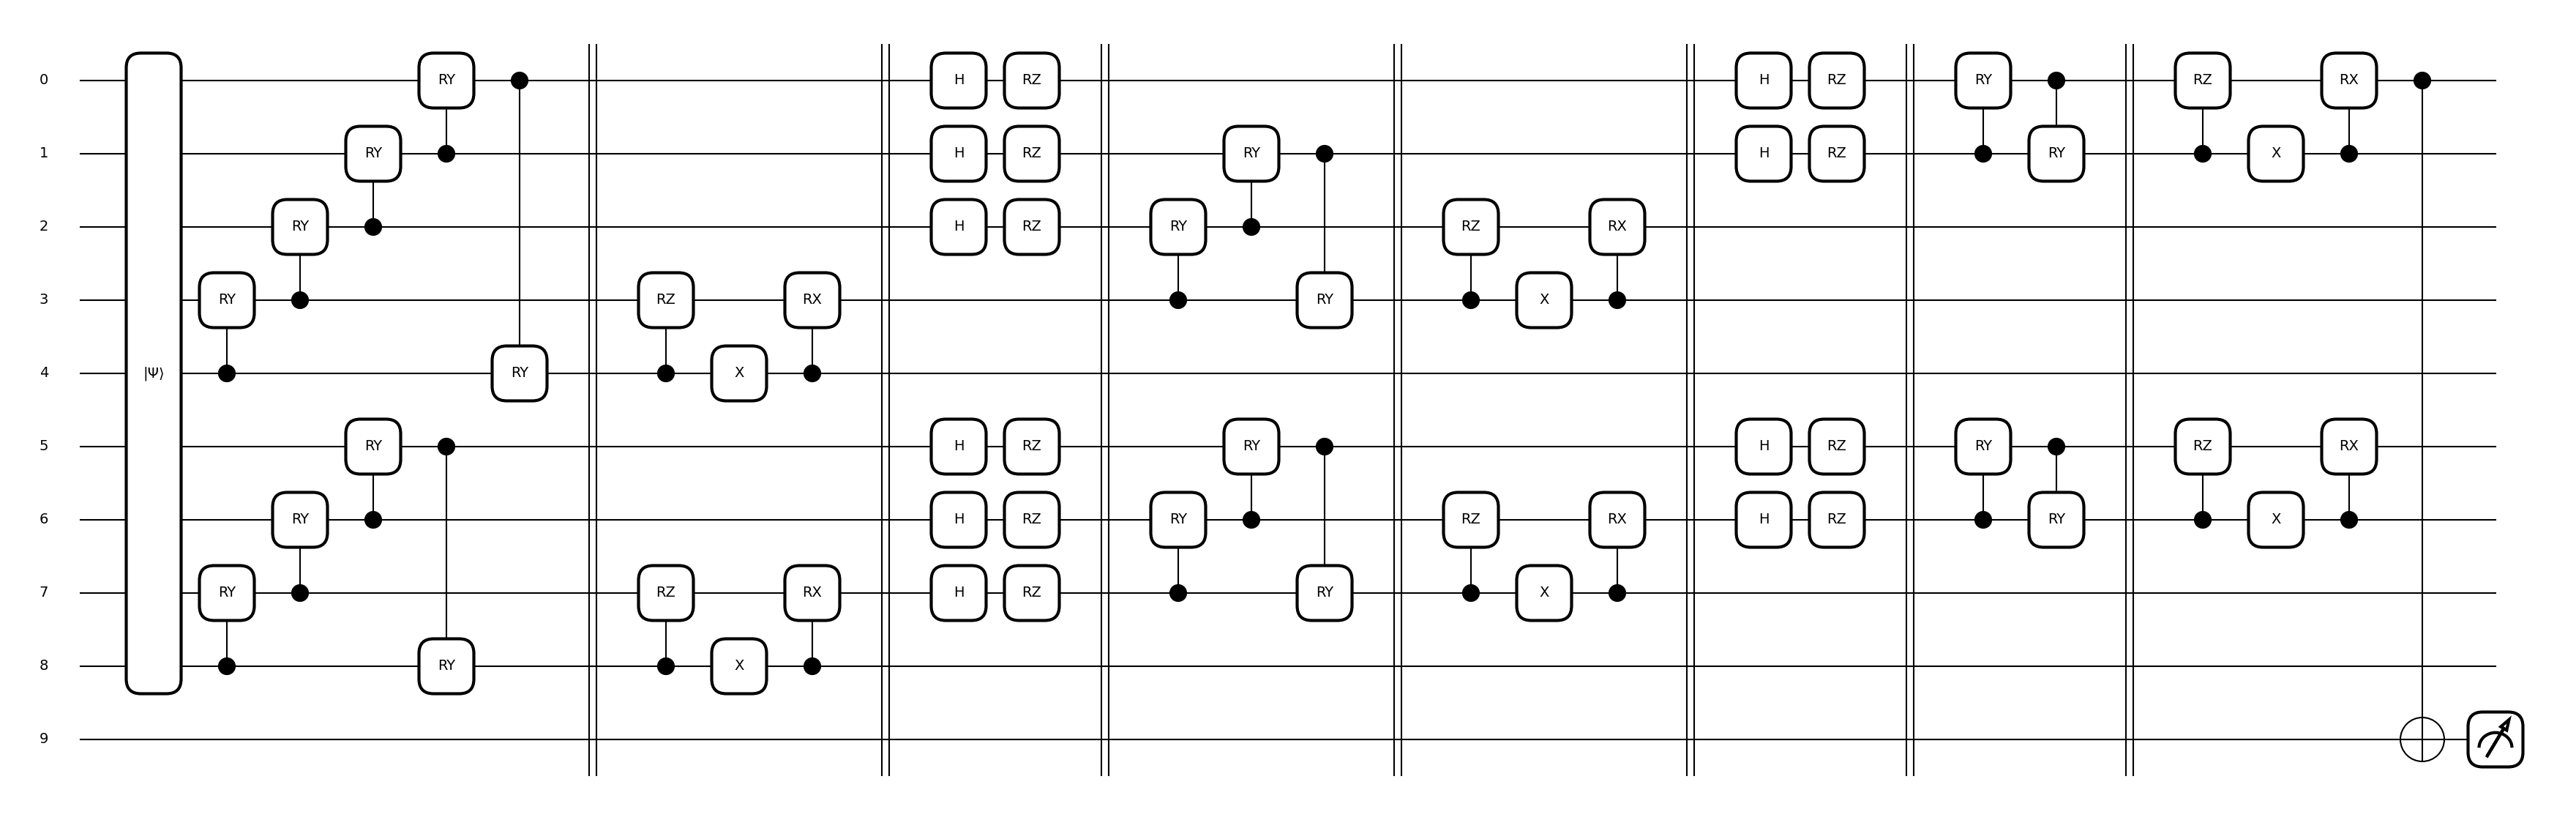

In [12]:
import matplotlib.pyplot as plt

# Random normalized feature vector (512 amplitudes)
features = np.random.rand(512)
features = features / np.linalg.norm(features)

# Number of parameters
num_phis = 35
phis = np.random.uniform(-np.pi, np.pi, size=num_phis)

# --- ASCII circuit diagram ---
drawer = qml.draw(quantum_circuit)
print(drawer(features, phis))

# --- Matplotlib circuit diagram ---
fig, ax = qml.draw_mpl(quantum_circuit)(features, phis)
plt.show()


In [13]:
class QCNN(torch.nn.Module):
    def __init__(self):
        super(QCNN, self).__init__()
        # Initialize the trainable quantum circuit parameters with uniform distribution
        torch.random.manual_seed(42)
        # Based on the quantum_circuit, we need 35 parameters (phis[0] to phis[34])
        self.phis = torch.nn.Parameter(torch.empty(35))
        torch.nn.init.uniform_(self.phis, a=-np.pi, b=np.pi)

    def forward(self, x):
        # Call the quantum circuit and return the expectation value
        # The quantum circuit returns a single expectation value for binary classification
        # It does not return log-probabilities directly for NLLLoss.
        # We will use BCEWithLogitsLoss and the output of the quantum circuit is the logit.
        # Ensure the features are normalized for Amplitude Embedding
        x_normalized = x / torch.linalg.norm(x, dim=1, keepdim=True)
        return quantum_circuit(features=x_normalized, phis=self.phis)

In [14]:
# Set up the model, optimizer, and loss function
model = QCNN()
optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()  # Use NLLLoss since output is probabilities

In [15]:
def compute_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / len(labels)
    return accuracy


In [18]:
from collections import defaultdict

# Initialize a dictionary to store counts per class
class_correct = defaultdict(int)
class_total = defaultdict(int)

test_outs = None
model.eval()

# List of class labels (binary classification)
class_labels = [0, 1]

with torch.no_grad():
    test_outputs = model(x_test_tensor / torch.linalg.norm(x_test_tensor, dim=1, keepdim=True))
    test_outs = test_outputs

    # For binary classification, use sigmoid and a threshold of 0.5
    probs = torch.sigmoid(test_outputs)
    predicted = (probs >= 0.5).float()

    # Calculate overall accuracy
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f"Overall Test Accuracy: {accuracy:.4f}")

    # Calculate accuracy per class
    for i in range(len(y_test_tensor)):
        label = int(y_test_tensor[i].item())  # Convert label to integer
        pred = int(predicted[i].item())      # Convert prediction to integer

        if label == pred:
            class_correct[label] += 1
        class_total[label] += 1

# Print accuracy for each class
for label in class_labels:
    if class_total[label] > 0:
        class_accuracy = class_correct[label] / class_total[label]
        print(f"Accuracy for class {label}: {class_accuracy:.4f}")
    else:
        print(f"No samples found for class {label}.")

Overall Test Accuracy: 0.8868
Accuracy for class 0: 0.0106
Accuracy for class 1: 0.9967


In [19]:
import matplotlib.pyplot as plt

# Dictionaries to store images that were correctly classified per class
correct_images = defaultdict(list)
incorrect_images = defaultdict(list)

with torch.no_grad():
    probs = torch.sigmoid(test_outs)
    predicted = (probs >= 0.5).float()

    for i in range(len(y_test_tensor)):
        label = int(y_test_tensor[i].item())
        pred = int(predicted[i].item())
        img = X_test[i]   # assuming X_test is numpy array of original test images

        if label == pred:
            correct_images[label].append(img)
        else:
            incorrect_images[label].append(img)


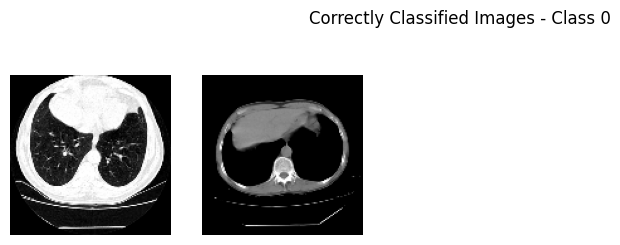

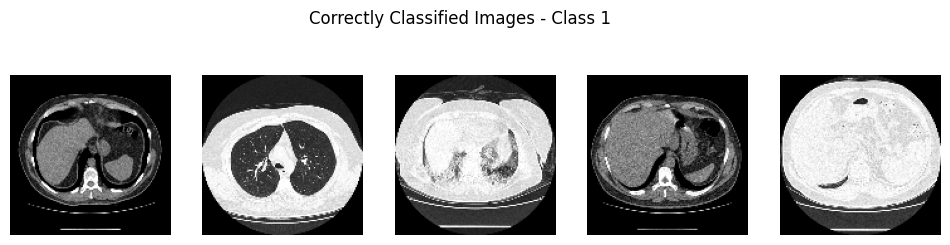

In [20]:
def show_images(images, title, n=5):
    plt.figure(figsize=(12, 3))
    for i in range(min(n, len(images))):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Show some correctly classified samples
for label in class_labels:
    if len(correct_images[label]) > 0:
        show_images(correct_images[label], f"Correctly Classified Images - Class {label}")


In [21]:
print(f"Accuracy for class {label}: {class_accuracy:.4f}")


Accuracy for class 1: 0.9967
